<table>
<tr style="background-color:#FFFFFF;">
<td width=15%>
    <table>
        <tr><img src="https://ensimag.grenoble-inp.fr/uas/alias2/LOGO/Grenoble+INP+-+Ensimag+-+Logo+-+2020+%28couleur%2C+RVB%29.png"></img>
        </tr>
    </table>
</td>
<td>
    <table>
        <tr><center><h3>Introduction to Lab Research, Mar 2021(adapted from Yann-Laurick Abé)</h3></center>
        </tr>
        <tr><center><h1>Probability Calibration for Image Classification Systems</h1></center>
        </tr>
    </table>
</td>
<td width=15%>
    <table>
        <tr><a href="mailto:junyi.zhong@etu.univ-grenoble-alpes.fr" style="font-size: 14px; font-weight: bold">Junyi ZHONG</a><br> (student) <br>
        </tr>
        <tr><a href="mailto:georges.quenot@imag.fr" style="font-size: 14px; font-weight: bold">Georges Quénot 
        </br></a> (supervisor) 
        </tr>   
    </table>
</td>
</tr>
</table>

# Imports and data processing

In [1]:
import math
import torch

import torch.nn as nn

import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skewnorm
from sklearn.model_selection import train_test_split

sns.set(context='notebook', style='darkgrid',
        palette='bright', font='sans-serif',
        font_scale=1, color_codes=True)

In [2]:
def ctime():
    if torch.cuda.is_available(): torch.cuda.synchronize()
    return(time.time())

In [3]:
train_batch_size = 400
test_batch_size = 400

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)

cuda:0


In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Network definition

In [6]:
class LeNet(nn.Module):
    def __init__(self, w = 32, h = 32, i = 3, n = [6, 16, 120, 84], o = 10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(i, n[0], 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(n[0], n[1], 5)
        self.fc1 = nn.Linear(n[1] * (w//4-3) * (h//4-3), n[2])
        self.fc2 = nn.Linear(n[2], n[3])
        self.fc3 = nn.Linear(n[3], o)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, torch.prod(torch.tensor(list(x.size()[1:]))).item())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

We load our pre-trained model.

In [7]:
PATH = './cifar_net.pth'
net = LeNet(n = [32, 32, 240, 120]).to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Tools

Here, are defined useful functions for the visualization work, and for the implementation of the experiments. Please skip directly to the next section to see the results.

In [8]:
def get_scores_labels(net, set, loader, batch_size, classes):
    scores = torch.zeros((len(set), len(classes)), dtype = torch.float32)
    labels = torch.zeros(len(set), dtype = torch.int64)
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            labels[i*batch_size:(i+1)*batch_size] = data[1]
            scores[i*batch_size:(i+1)*batch_size] = net(data[0].to(device)).to('cpu')
    return scores, labels

In [9]:
def get_accuracy(scores, labels, classes):
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    predicted = torch.argmax(scores, 1)
    c = (predicted == labels).squeeze()
    for i in range(len(labels)):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1
    return class_correct, class_total

In [10]:
def positive_and_negative(scores, labels, class_id):
    size_dataset = labels.shape[0]
    pos_neg_scores = np.empty(size_dataset, dtype = np.float32)
    ipos, ineg = 0, size_dataset
    for i in range(size_dataset):
        if class_id == labels[i]:
            pos_neg_scores[ipos] = scores[i][class_id]
            ipos += 1
        else:
            ineg -= 1
            pos_neg_scores[ineg] = scores[i][class_id]
    return pos_neg_scores[:ipos], pos_neg_scores[ipos:]

In [11]:
def initialize_subplots(classes, w=30, h=20):
    fig = plt.figure(figsize=(w, h), clear=True)
    plt.subplots_adjust(left = 0.125, right = 0.9, bottom = 0.08, top = 0.92, wspace = 0.2, hspace = 0.7)
    nb_class = len(classes)
    return fig, nb_class


def plot_pdf_pos_neg_calib(scores, labels, classes, vertical_range=(-0.02, 0.22), save=True, format_save="pdf",
                           net_type="lenet", step="train", legend=True):
    """
    Compute and plots the histograms of score values for the positive and negative samples
    for each class for the "step" set of CIFAR-10, along with skew norm distribution plots
    and calibrated probabilities.
    """
    
    fig, nb_class = initialize_subplots(classes)
    
    for class_id in range(nb_class):
        positive, negative = positive_and_negative(scores, labels, class_id)
        horizontal_range = np.min(negative), np.max(positive)
        z = np.linspace(horizontal_range[0], horizontal_range[1], 100)  # useful for skew norm distribution plots

        # histograms
        ax1 = plt.subplot(nb_class//2, nb_class//2, class_id+1)
        if step=="train":
            ax1.set_xlim(-20, 30)
        if step=="test":
            ax1.set_xlim(-20, 40)
        ax1.set_ylim(vertical_range[0], vertical_range[1])
        ax1.hist(positive, bins=30, range=horizontal_range,
                 density=True, histtype='step', color='green')
        ax1.hist(negative, bins=30, range=horizontal_range,
                 density=True, histtype='step', color='red')
        color = 'black'
        ax1.set_xlabel('scores')
        ax1.set_ylabel('histograms', color=color)
        
        # skew norm distribution plots
        a_est_pos, loc_est_pos, scale_est_pos = skewnorm.fit(positive)
        pdf_pos = skewnorm.pdf(z, a_est_pos, loc=loc_est_pos, scale=scale_est_pos)
        ax1.plot(z, pdf_pos,'g-', alpha=0.9, lw=1)
        
        a_est_neg, loc_est_neg, scale_est_neg = skewnorm.fit(negative)
        pdf_neg = skewnorm.pdf(z, a_est_neg, loc=loc_est_neg, scale=scale_est_neg)
        ax1.plot(z, pdf_neg,'r-', alpha=0.9, lw=1)
        
        # calibrated probabilities
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:blue'
        ax2.set_ylabel('calibrated probabilities', color=color)
        ax2.set_ylim(-0.1, 1.1)
        n_pos, n_neg = len(positive), len(negative)
        ax2.plot(z, n_pos*pdf_pos/(n_pos*pdf_pos+n_neg*pdf_neg),color=color, alpha=0.9, lw=1)
        ax2.tick_params(axis='y', labelcolor=color)
        fig.tight_layout()
    
        # plot per graph legend
        plt.title(classes[class_id])

    if legend:
        plt.figlegend(("positive", "negative"))
    if save:
        plt.savefig(f'{net_type}_{step}_distrib_scores.{format_save}', format=format_save, bbox_inches='tight')

# Training scores analysis

Now, we visualize for each class, the distribution of the scores for positive
and negative outputs over the training set.

In [12]:
train_scores, train_labels = get_scores_labels(net, trainset, trainloader, train_batch_size,classes)
class_correct, class_total = get_accuracy(train_scores, train_labels, classes)
print('Overall accuracy  : %2.1f %%' % (
    100 * sum(class_correct) / sum(class_total)))
for i in range(10):
    print('Accuracy of %5s : %2.1f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Overall accuracy  : 89.1 %
Accuracy of plane : 90.9 %
Accuracy of   car : 95.8 %
Accuracy of  bird : 88.2 %
Accuracy of   cat : 75.3 %
Accuracy of  deer : 90.7 %
Accuracy of   dog : 78.2 %
Accuracy of  frog : 93.7 %
Accuracy of horse : 88.9 %
Accuracy of  ship : 95.8 %
Accuracy of truck : 93.3 %


In [13]:
img_x_scores_train = train_scores.numpy()  # dumping the arrays of image×score values over the training set

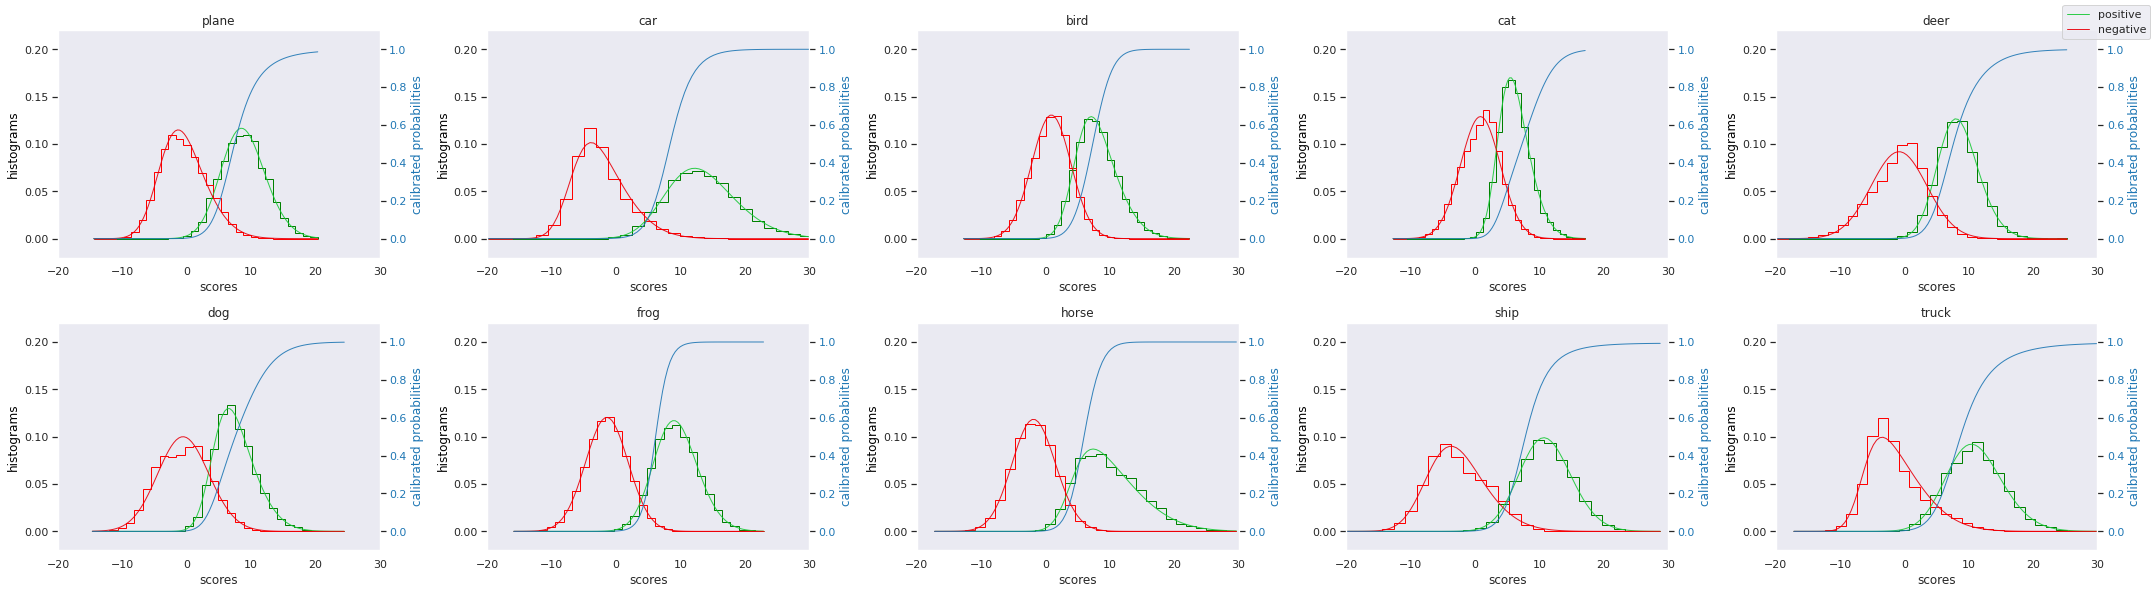

In [14]:
sns.set(context='notebook', style='dark',
        palette='bright', font='sans-serif',
        font_scale=1, color_codes=True)

plot_pdf_pos_neg_calib(img_x_scores_train, train_labels, classes, step="train", save=False)

sns.set(context='notebook', style='darkgrid',
        palette='bright', font='sans-serif',
        font_scale=1, color_codes=True)

# Test scores analysis

We visualize for each class, the distribution of the scores for positive
and negative outputs over the test set.

In [15]:
test_scores, test_labels = get_scores_labels(net, testset, testloader, test_batch_size,classes)
class_correct, class_total = get_accuracy(test_scores, test_labels, classes)
print('Overall accuracy  : %2.1f %%' % (
    100 * sum(class_correct) / sum(class_total)))
for i in range(10):
    print('Accuracy of %5s : %2.1f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Overall accuracy  : 81.1 %
Accuracy of plane : 84.0 %
Accuracy of   car : 90.8 %
Accuracy of  bird : 77.2 %
Accuracy of   cat : 61.0 %
Accuracy of  deer : 83.9 %
Accuracy of   dog : 68.4 %
Accuracy of  frog : 88.6 %
Accuracy of horse : 81.3 %
Accuracy of  ship : 88.7 %
Accuracy of truck : 87.3 %


In [16]:
img_x_scores_test = test_scores.numpy()  # dumping the arrays of image×score values over the test set

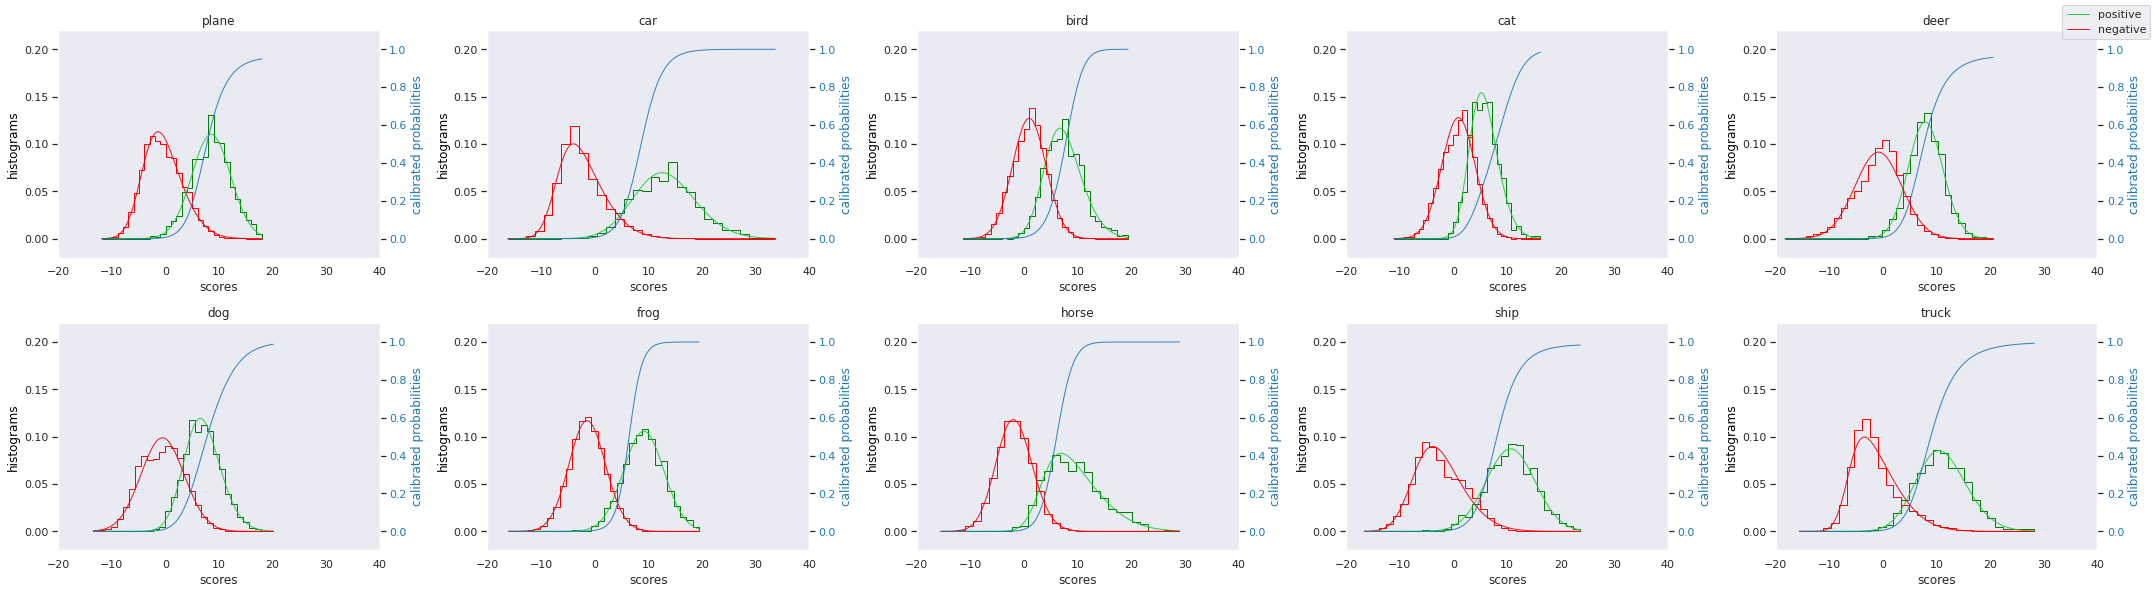

In [17]:
sns.set(context='notebook', style='dark',
        palette='bright', font='sans-serif',
        font_scale=1, color_codes=True)

plot_pdf_pos_neg_calib(img_x_scores_test, test_labels, classes, step="test", save=False)

sns.set(context='notebook', style='darkgrid',
        palette='bright', font='sans-serif',
        font_scale=1, color_codes=True)

# First experiment

Here, the goal is to assess the _consistency_ of the calibration.

In [18]:
def get_pos_neg_scores(scores, class_id):
    size_dataset = scores.shape[0]
    pos_neg_scores = np.empty(size_dataset, dtype = np.float32)
    ipos, ineg = 0, size_dataset
    for i in range(size_dataset):
        if class_id == np.argmax(scores[i]):
            pos_neg_scores[ipos] = scores[i][class_id]
            ipos += 1
        else:
            ineg -= 1
            pos_neg_scores[ineg] = scores[i][class_id]
    return pos_neg_scores[:ipos], pos_neg_scores[ipos:]
    

def plot_experiment1(scores, labels, classes, vertical_range=(-0.1, 1.1), save=True, format_save="pdf",
                           net_type="lenet", step="train", legend=True, eta=5):
    
    _, nb_class = initialize_subplots(classes)
    
    # split the test set
    scores1, scores2 = train_test_split(scores, test_size=0.5)
    for class_id in range(nb_class):
        positive1, negative1 = get_pos_neg_scores(scores1, class_id)
        positive2, negative2 = get_pos_neg_scores(scores2, class_id)
        horizontal_range1 = min(np.min(scores1, 1))+eta, max(np.max(scores1, 1))
        horizontal_range2 = min(np.min(scores2, 1))+eta, max(np.max(scores2, 1))
        horizontal_range = min(horizontal_range1[0], horizontal_range2[0]), \
        max(horizontal_range1[1], horizontal_range2[1])
        z = np.linspace(horizontal_range[0], horizontal_range[1], 100)
        plt.subplot(nb_class//2, nb_class//2, class_id+1)
        plt.ylim(vertical_range)
        
        # plot curve 1
        a_est_pos1, loc_est_pos1, scale_est_pos1 = skewnorm.fit(positive1)
        pdf_pos1 = skewnorm.pdf(z, a_est_pos1, loc=loc_est_pos1, scale=scale_est_pos1)
        a_est_neg1, loc_est_neg1, scale_est_neg1 = skewnorm.fit(negative1)
        pdf_neg1 = skewnorm.pdf(z, a_est_neg1, loc=loc_est_neg1, scale=scale_est_neg1)
        n_pos1, n_neg1 = len(positive1), len(negative1)
        calib_probas1 = n_pos1*pdf_pos1/(n_pos1*pdf_pos1+n_neg1*pdf_neg1)
        plt.plot(z, calib_probas1, 'b-', alpha=0.9, lw=1)
        
        # plot curve 2
        a_est_pos2, loc_est_pos2, scale_est_pos2 = skewnorm.fit(positive2)       
        pdf_pos2 = skewnorm.pdf(z, a_est_pos2, loc=loc_est_pos2, scale=scale_est_pos2)
        a_est_neg2, loc_est_neg2, scale_est_neg2 = skewnorm.fit(negative2)
        pdf_neg2 = skewnorm.pdf(z, a_est_neg2, loc=loc_est_neg2, scale=scale_est_neg2)
        n_pos2, n_neg2 = len(positive2), len(negative2)
        calib_probas2 = n_pos2*pdf_pos2/(n_pos2*pdf_pos2+n_neg2*pdf_neg2)
        plt.plot(z, calib_probas2, 'r-', alpha=0.9, lw=1)
        
        # plot euclidean norm between the two curves
        plt.plot(z, np.absolute(calib_probas1 - calib_probas2), 'black', alpha=0.7, lw=3)
        
        plt.title(classes[class_id])

    if legend:
        plt.figlegend(("first partition", "second partition", "euclidean distance between 1 & 2"))
    if save:
        plt.savefig(f'{net_type}_{step}.{format_save}', format=format_save, bbox_inches='tight')

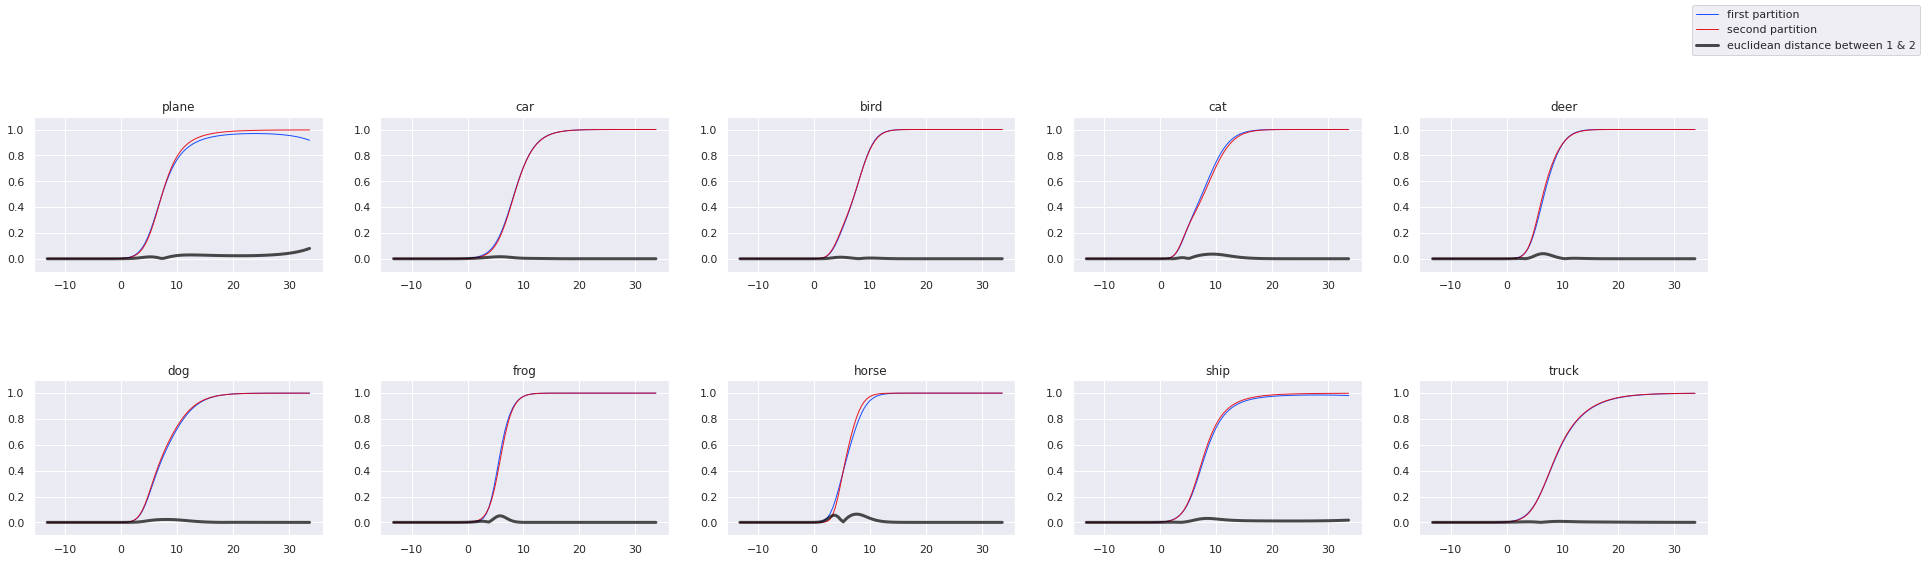

In [19]:
plot_experiment1(img_x_scores_test, test_labels, classes, step="exp1", save=False)

# Second experiment

Here, the goal is to assess the exactness of the calibration.

In [20]:
sns.set(context='notebook', style='white',
        palette='bright', font='sans-serif',
        font_scale=1, color_codes=True)

In [21]:
def get_r_delta_r_class_id(scores, labels, class_id, intervals, calibration=True):
    if calibration:
        positive, negative = positive_and_negative(scores, labels, class_id)
        a_est_pos, loc_est_pos, scale_est_pos = skewnorm.fit(positive)
        a_est_neg, loc_est_neg, scale_est_neg = skewnorm.fit(negative)
        pdf_pos_x = skewnorm.pdf(scores[:,class_id], a_est_pos, loc=loc_est_pos, scale=scale_est_pos)
        pdf_neg_x = skewnorm.pdf(scores[:,class_id], a_est_neg, loc=loc_est_neg, scale=scale_est_neg)
        n_pos, n_neg = len(positive), len(negative)
        posterior_probability_x = n_pos*pdf_pos_x/(n_pos*pdf_pos_x+n_neg*pdf_neg_x)
    else:
        posterior_probability_x = scores[:,class_id]

    r = np.empty(len(intervals), dtype=np.float32)
    delta_r = np.empty(len(intervals), dtype=np.float32)
    n_Is = []
    for k, I in enumerate(intervals):
        n_pos_I, n_neg_I = 0, 0
        size_dataset = labels.shape[0]        
        for i in range(size_dataset):
            if I[0] <= posterior_probability_x[i] <= I[1]:
                if labels[i] == class_id: n_pos_I += 1
                else: n_neg_I += 1
        n_Is.append((n_pos_I, n_neg_I))
        r[k] = n_pos_I/(n_pos_I + n_neg_I + 1) # We add 1 to avoid division by zero
        delta_r[k] = math.sqrt(r[k]*(1-r[k])/(n_pos_I + n_neg_I + 1)) # We add 1 to avoid division by zero
    return r, delta_r, n_Is

def plot_experiment2_class_id(scores, labels, class_id, delta_p=0.05, calibration=True, nb_class=10):

    # experiment parameters
    num = int(1/delta_p)+1
    probabilities = np.linspace(0, 1, num)
    intervals = np.array([(i-delta_p, i+delta_p) for i in probabilities[1:-1]])
    
    # r and delta_r estimations for all intervals
    r, delta_r, n_Is = get_r_delta_r_class_id(scores, labels, class_id, intervals, calibration=calibration)
        
    # plots
    fig, ax1 = plt.subplots()
    color="black"
    ax1.set_ylabel('probabilities', color=color)
    ax1.plot(probabilities[1:-1], r, 'b.-', alpha=1, lw=1)
    # ax1.plot(probabilities[1:-1], probabilities[1:-1], 'k--')
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.fill_between(probabilities[1:-1], r+delta_r, r-delta_r, facecolor='blue', alpha=0.3)
    plt.title(classes[class_id])
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = "tab:red"
    ax2.set_ylim(0, 1000)
    ax2.set_ylabel('#pos_I + #neg_I', color=color)  # we already handled the x-label with ax1
    t = [sum(n_Is[i]) for i in range(len(n_Is))]
    ax2.plot(probabilities[1:-1], t, "r.")
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    
def plot_experiment2(scores, labels, classes, delta_p=0.05, save=True, format_save="pdf",
                    net_type="lenet", step="exp2", calibration=True):
    fig, nb_class = initialize_subplots(classes)
    for class_id in range(nb_class):
        ax1 = plt.subplot(nb_class//2, nb_class//2, class_id+1)
        
        # experiment parameters
        num = int(1/delta_p)+1
        probabilities = np.linspace(0, 1, num)
        intervals = np.array([(i-delta_p, i+delta_p) for i in probabilities[1:-1]])

        # r and delta_r estimations for all intervals
        r, delta_r, n_Is = get_r_delta_r_class_id(scores, labels, class_id, intervals, calibration=calibration)

        # plots
        color="black"
        ax1.set_ylabel('probabilities', color=color)
        ax1.plot(probabilities[1:-1], r, 'b-', alpha=1, lw=1)
        ax1.plot(probabilities[1:-1], probabilities[1:-1], 'k--')
        ax1.fill_between(probabilities[1:-1], r+delta_r, r-delta_r, facecolor='blue', alpha=0.3)
        plt.title(classes[class_id])

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = "tab:red"
        ax2.set_ylim(0, 1000)
        ax2.set_ylabel('#pos_I + #neg_I', color=color)  # we already handled the x-label with ax1
        t = [sum(n_Is[i]) for i in range(len(n_Is))]
        ax2.plot(probabilities[1:-1], t, "r.")
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        
    if save:
        plt.savefig(f'{net_type}_{step}.{format_save}', format=format_save, bbox_inches='tight')

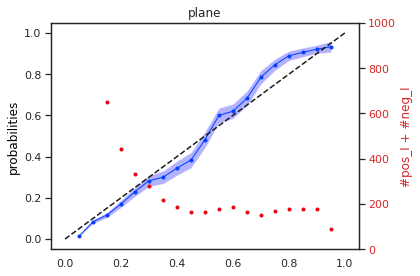

In [22]:
plot_experiment2_class_id(img_x_scores_test, test_labels, 0)

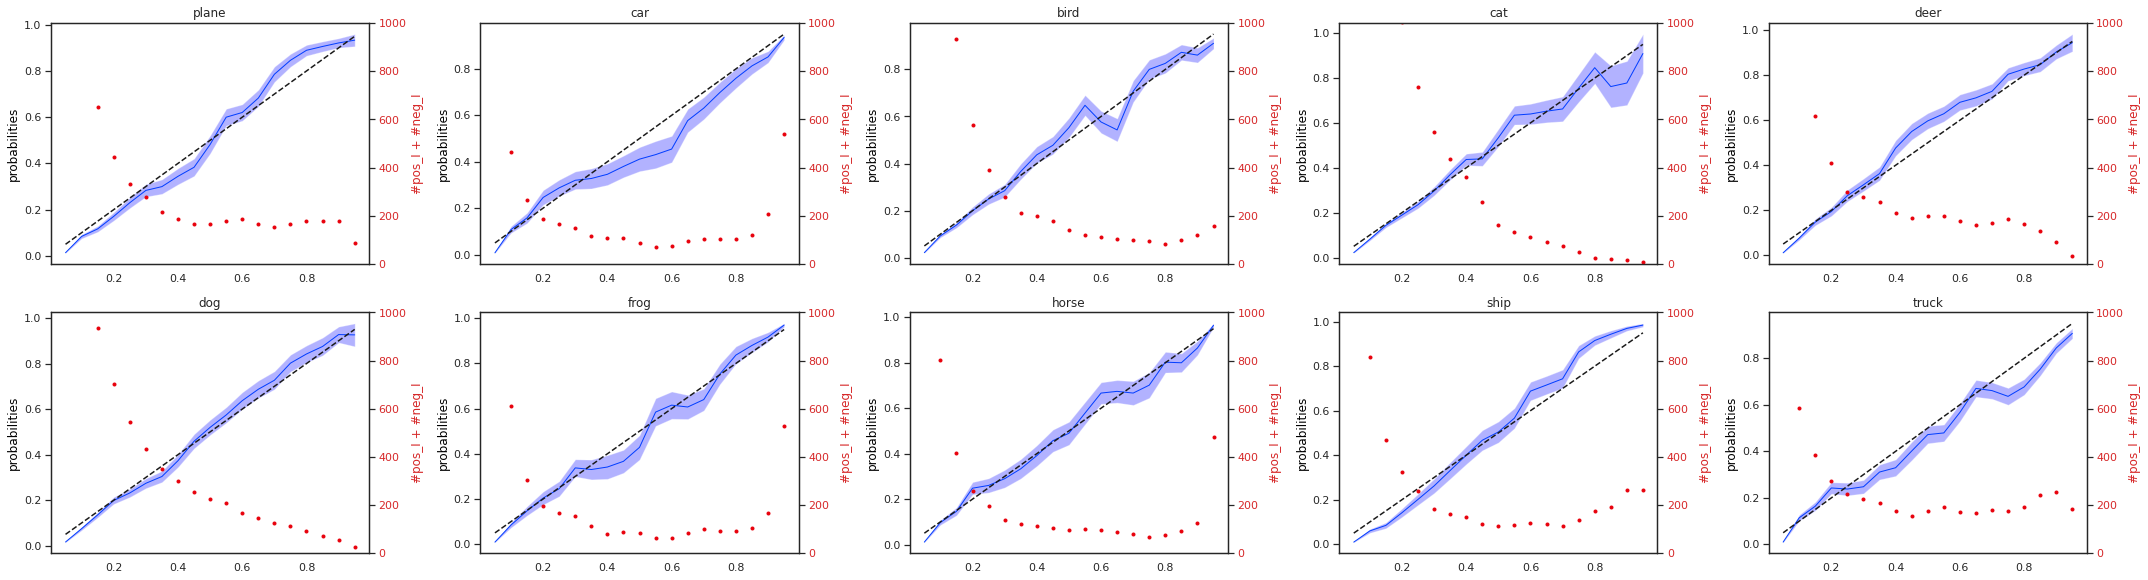

In [23]:
plot_experiment2(img_x_scores_test, test_labels, classes, save=True)

# Third experiment

Here, the goal is to compare softmax normalization with our calibration method.

In [24]:
# we apply the softmax to the FC output over the test set
test_scores_softmax = nn.Softmax(dim=1)(test_scores)

In [25]:
img_x_scores_test_softmax = test_scores_softmax.numpy()

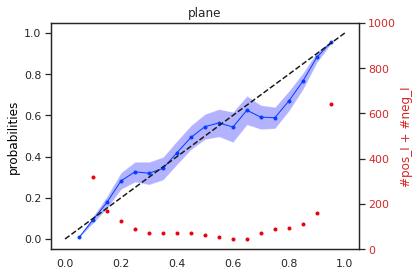

In [26]:
plot_experiment2_class_id(img_x_scores_test_softmax, test_labels, 0, calibration=False)

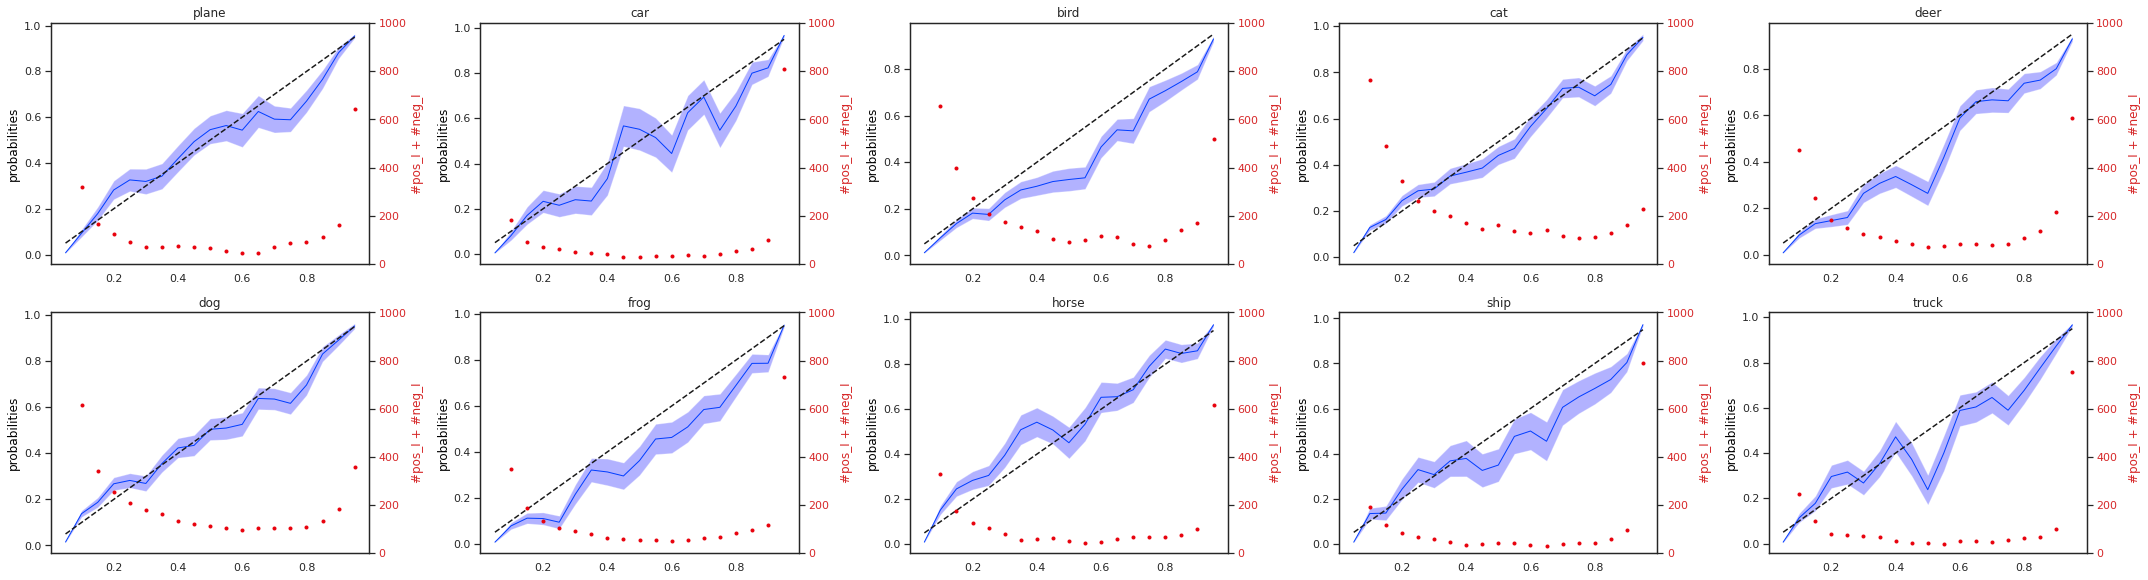

In [27]:
plot_experiment2(img_x_scores_test_softmax, test_labels, classes, step="exp3", calibration=False, save=True)

In [28]:
import operator
my_list = [[1, 2], [4,1]]
my_list.sort(key=operator.itemgetter(1))
print(my_list)

[[4, 1], [1, 2]]


# Fourth experiment
$$\sigma(x) = \frac{1}{1+e^{-x}}$$
$$\sigma^{-1}(y) = \log y - \log (1-y) $$

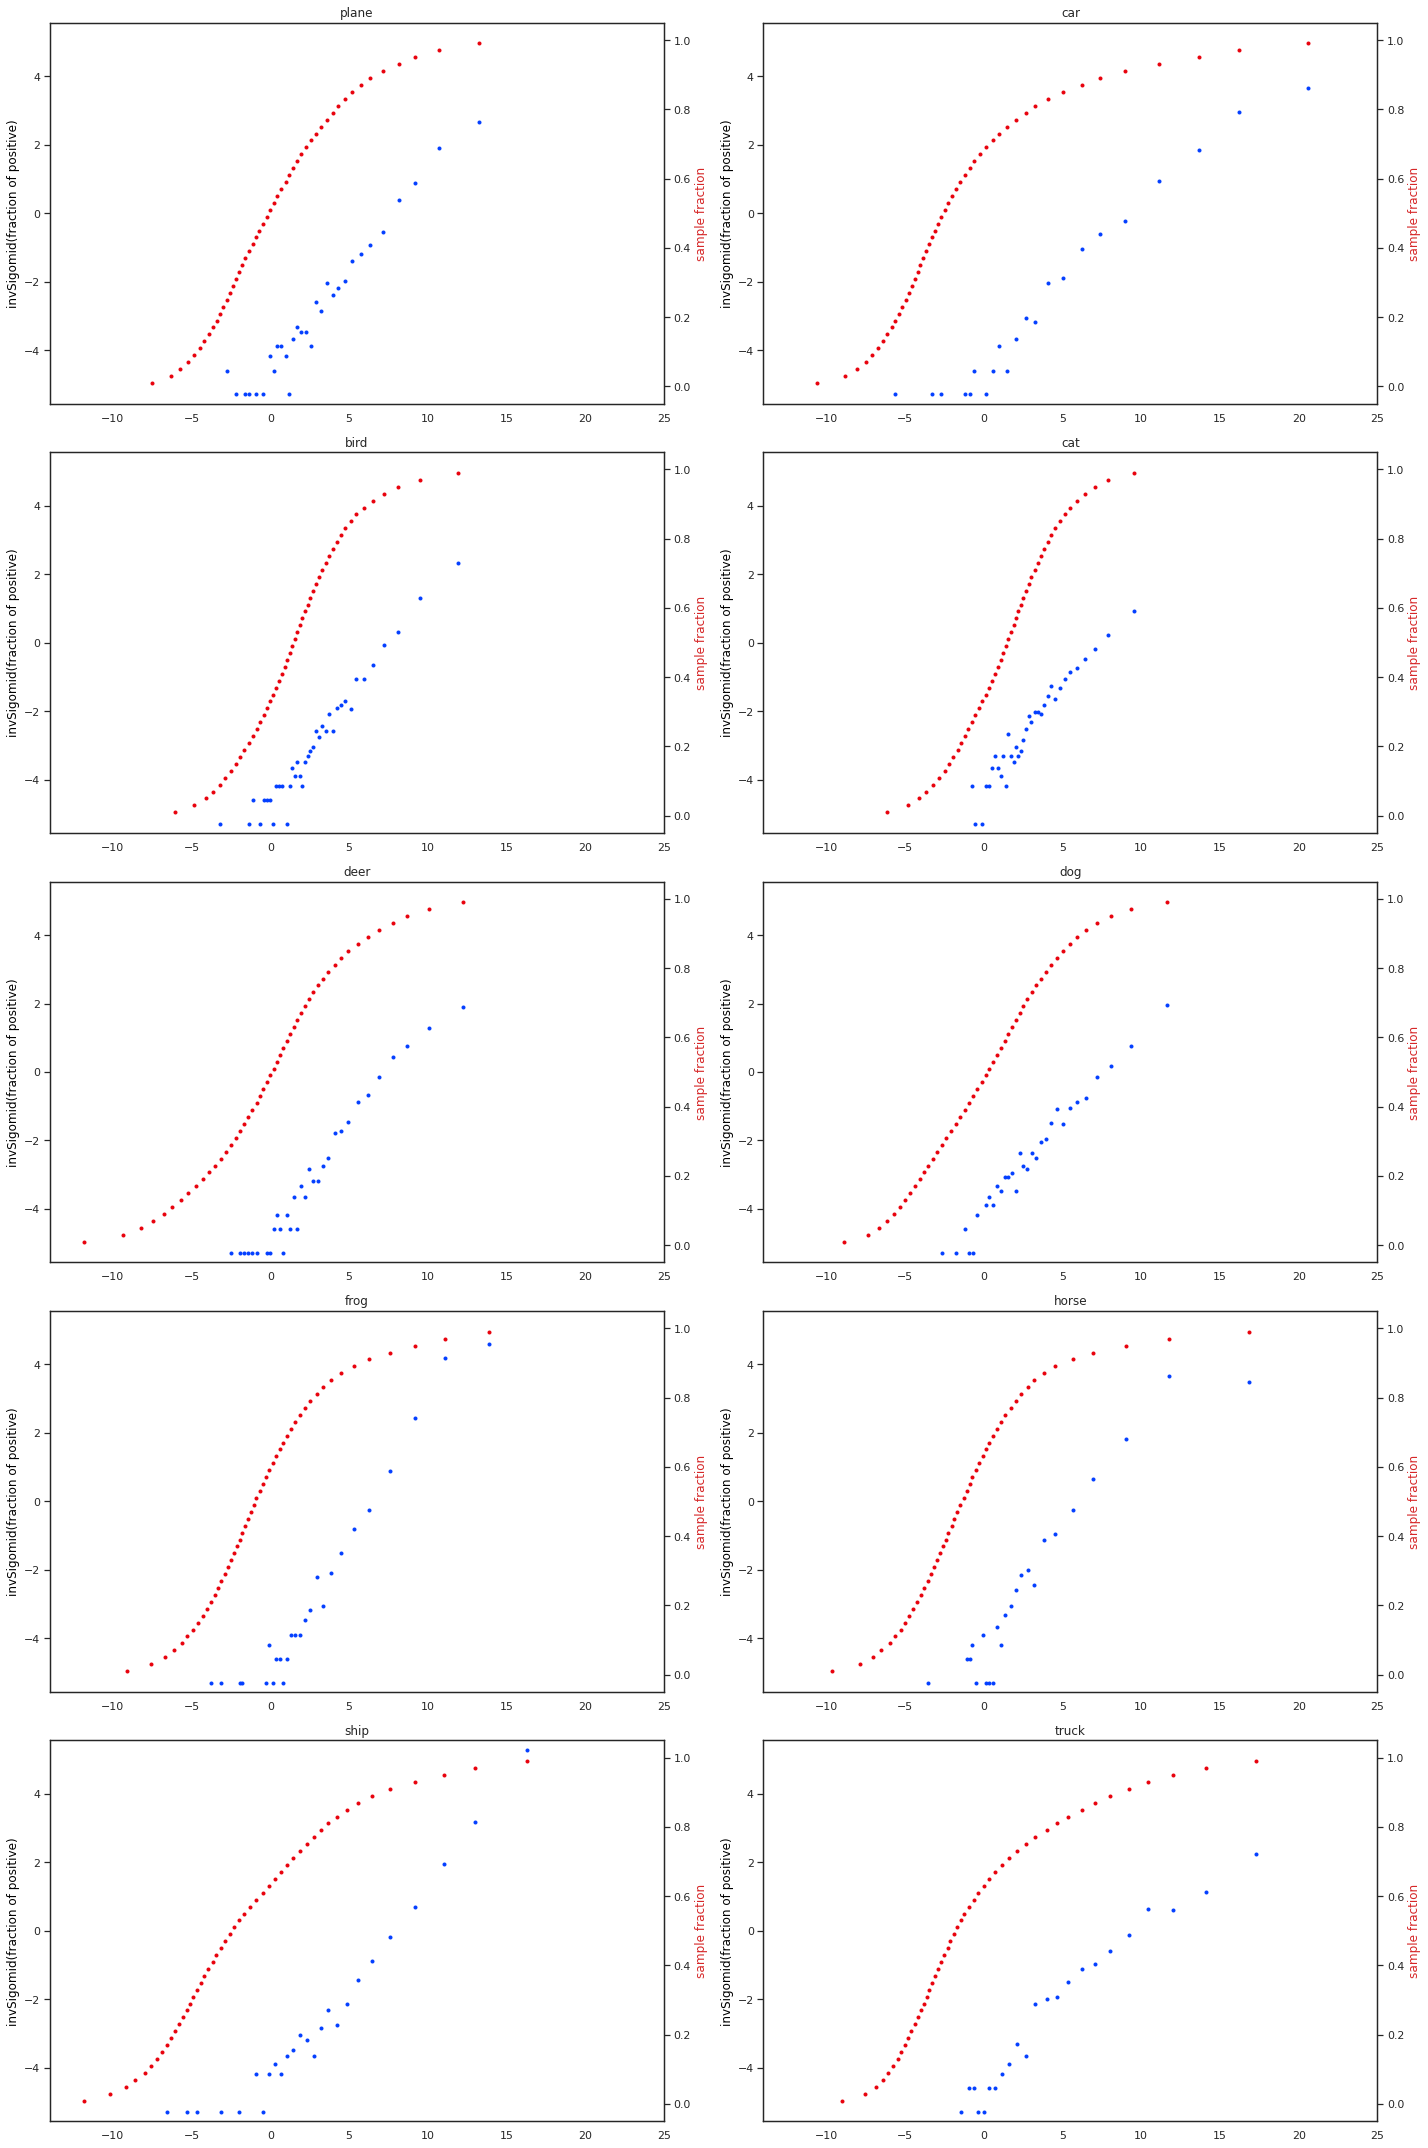

In [29]:
def invSigmoid(y):
    if (y <= 0): x = -100.0
    elif (y >= 1): x = 100.0
    else: x = math.log(y)-math.log(1-y)
    return(x)

vInvSigmoid = np.vectorize(invSigmoid)

def plot_experiment4(scores, labels, classes, nb_intervals=50, interval_size=200):
    score_range = 1.05*np.min(scores)-0.05*np.max(scores), 1.05*np.max(scores)-0.05*np.min(scores)
    fig, nb_classes = initialize_subplots(classes, 20, 30)
    nb_samples = labels.shape[0]
    begin_range = nb_samples-interval_size
    intervals = np.transpose([np.linspace(0, nb_samples-interval_size, nb_intervals),
                             np.linspace(interval_size, nb_samples, nb_intervals)]).astype(int)
    interval_centers = np.linspace(interval_size//2, nb_samples-interval_size//2, nb_intervals).astype(int)
    r, dr = np.empty(nb_intervals), np.empty(nb_intervals)
    for class_id in range(nb_classes):
        scores_id = scores[:, class_id]
        labels_id = (labels == class_id).astype(int)
        sort_id = scores_id.argsort()
        scores_id = scores_id[sort_id]
        labels_id = labels_id[sort_id]
        for k in range(nb_intervals):
            n_pos = 0
            for i in range(*intervals[k].tolist()): n_pos += labels_id[i]
            r[k] = n_pos/interval_size
            dr[k] = math.sqrt(r[k]*(1-r[k])/interval_size)
        ax1 = plt.subplot(nb_classes//2, 2, class_id+1)
        # plots
        # ax1.set_xlim(-0.03*nb_samples,1.03*nb_samples)
        # ax1.set_xlim(score_range)
        ax1.set_xlim(-14,25)
        ax1.set_ylim(-1.05*math.log(interval_size), +1.05*math.log(interval_size))
        # ax1.set_ylim(-0.05, 1.05)
        color="black"
        ax1.set_ylabel('invSigomid(fraction of positive)', color=color)
        ax1.plot(scores_id[interval_centers], vInvSigmoid(r), 'b.', alpha=1, lw=1)
        # ax1.fill_between(scores_id[interval_centers], vInvSigmoid(r+dr), vInvSigmoid(r-dr), facecolor='blue', alpha=0.3)
        # ax1.plot(scores_id[interval_centers], r, 'b-', alpha=1, lw=1)
        # ax1.fill_between(scores_id[interval_centers], r+dr, r-dr, facecolor='blue', alpha=0.3)
        # ax1.plot(interval_centers, r, 'b-', alpha=1, lw=1)
        # ax1.fill_between(interval_centers, r+dr, r-dr, facecolor='blue', alpha=0.3)
        plt.title(classes[class_id])

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = "tab:red"
        ax2.set_ylim(-0.05, 1.05)
        ax2.set_ylabel('sample fraction', color=color)  # we already handled the x-label with ax1
        ax2.plot(scores_id[interval_centers], interval_centers/nb_samples, "r.")

        # ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        # color = "tab:red"
        # ax2.set_ylim(score_range)
        # ax2.plot(interval_centers, scores_id[interval_centers], "r.")

        fig.tight_layout()  # otherwise the right y-label is slightly clipped

plot_experiment4(test_scores.numpy(), test_labels.numpy(), classes)

In [30]:
from scipy.stats import expon
from statistics import mean, pstdev
n = 1000000
scale = np.empty(n)
for i in range(n):
    data = expon.rvs(0.0, 1.5, 10)
    loc, scale[i] = expon.fit(data, floc=0)
print(scale.mean(), scale.std())

1.500949870600517 0.47445222354566974


In [31]:
from scipy.stats import expon
from statistics import mean, pstdev
n = 1000000
scale = np.empty(n)
for i in range(n):
    data = expon.rvs(0.0, 1.5, 100)
    loc, scale[i] = expon.fit(data, floc=0)
print(scale.mean(), scale.std())

1.499944279276499 0.15011125157534133


In [32]:
from scipy.stats import expon
from statistics import mean, pstdev
n = 100000
scale = np.empty(n)
for i in range(n):
    data = expon.rvs(0.0, 1.5, 1000)
    loc, scale[i] = expon.fit(data, floc=0)
print(scale.mean(), scale.std())

1.499872727890016 0.047444456742322935


In [33]:
from scipy.stats import expon
from statistics import mean, pstdev
n = 10000
scale = np.empty(n)
for i in range(n):
    data = expon.rvs(0.0, 1.5, 10000)
    loc, scale[i] = expon.fit(data, floc=0)
print(scale.mean(), scale.std())

1.4998492805416477 0.015175448394565102


In [34]:
from scipy.stats import expon
from statistics import mean, pstdev
n = 1000000
scale = np.empty(n)
for i in range(n):
    data = expon.rvs(1.0, 1.5, 100)
    loc, scale[i] = expon.fit(data, floc=0)
print(scale.mean(), scale.std())

2.5001291832122012 0.15004556200618915


In [35]:
from scipy.stats import expon
from statistics import mean, pstdev
n = 1000000
loc = np.empty(n)
scale = np.empty(n)
for i in range(n):
    data = expon.rvs(1.0, 1.5, 10)
    loc[i], scale[i] = expon.fit(data)
print(loc.mean(), loc.std())
print(scale.mean(), scale.std())

1.1499349424952685 0.14997108913823512
1.349328233153488 0.44965563832475747


In [36]:
from scipy.stats import expon
from statistics import mean, pstdev
n = 1000000
loc = np.empty(n)
scale = np.empty(n)
for i in range(n):
    data = expon.rvs(1.0, 1.5, 100)
    loc[i], scale[i] = expon.fit(data)
print(loc.mean(), loc.std())
print(scale.mean(), scale.std())

1.0150072652161177 0.015000916710463467
1.4850840026479992 0.1491351311600641


In [37]:
from scipy.stats import expon
from statistics import mean, pstdev
n = 100000
loc = np.empty(n)
scale = np.empty(n)
for i in range(n):
    data = expon.rvs(1.0, 1.5, 1000)
    loc[i], scale[i] = expon.fit(data)
print(loc.mean(), loc.std())
print(scale.mean(), scale.std())

1.001500716708724 0.0015049437622978183
1.4987764485739963 0.047427985493755945
